## Example of a cruise control

### 1. Simulate the plant and controller with finite differences

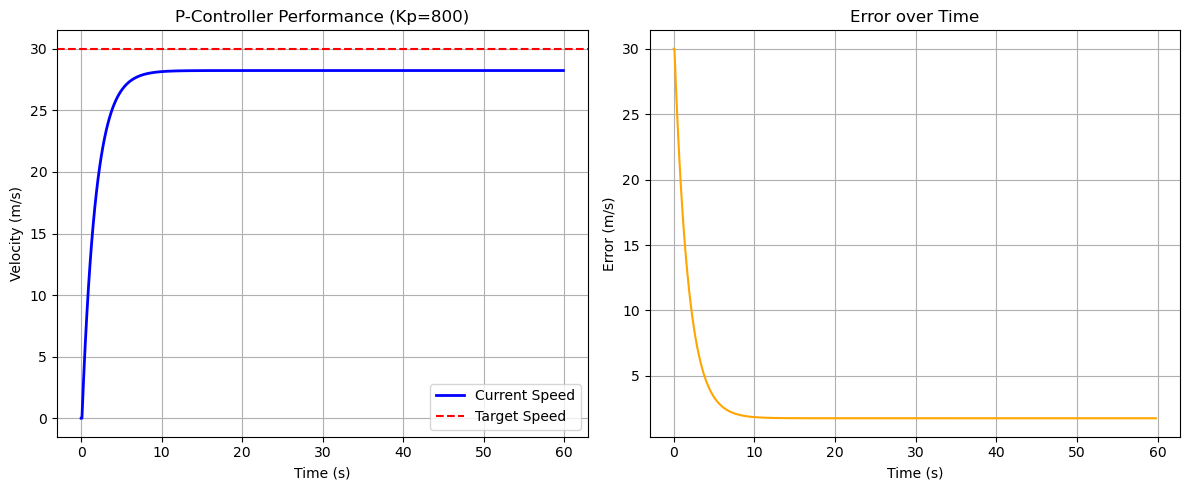

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# System Parameters
m = 1500      # Mass of the car (kg)
b = 50        # Aerodynamic drag/friction coefficient (N*s/m)
dt = 0.1      # Time step (seconds)
t_final = 60  # Simulation duration (seconds)
t = np.arange(0, t_final, dt)

# Controller Parameters
v_target = 30 # Target speed (m/s) -> roughly 108 km/h
Kp = 800      # Proportional Gain (Adjust this to see different behaviors)

# Initialize Arrays
v = np.zeros(len(t)) # Velocity over time
v[0] = 0             # Start from standstill
error_list = []

# Modified loop to simulate a lag in engine response
# no lag means lag_steps = 1
lag_steps = 1
for i in range(1, len(t)):
    
    # Calculate the error
    error = v_target - v[i-1]
    error_list.append(error)

    if i > lag_steps:
        # The controller reacts to the error from 0.5 seconds ago
        delayed_error = v_target - v[i-lag_steps]
        F = Kp * delayed_error
    else:
        F = 0
    
    # Physics remains the same
    dv_dt = (F - b * v[i-1]) / m
    v[i] = v[i-1] + dv_dt * dt



# Visualization
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(t, v, label='Current Speed', color='blue', linewidth=2)
plt.axhline(y=v_target, color='r', linestyle='--', label='Target Speed')
plt.title(f'P-Controller Performance (Kp={Kp})')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(t[:-1], error_list, color='orange')
plt.title('Error over Time')
plt.xlabel('Time (s)')
plt.ylabel('Error (m/s)')
plt.grid(True)

plt.tight_layout()
plt.show()

### 2. Transfer functions

The differential equation is

$$ m\frac{\mathrm{d} v}{\mathrm{d}t} = F_\mathrm{engine} - b\cdot v $$

The transfer function becomes 

$$ G(s) = \frac{Y(s)}{U(s)} = \frac{1}{m s + b}$$

With the feedback control we get


$$ T(s) = \frac{V(s)}{V_{sp}} = \frac{ C(s) G(s) }{1+C(s) G(s)} = \frac{K_p}{ms +b + K_p} $$


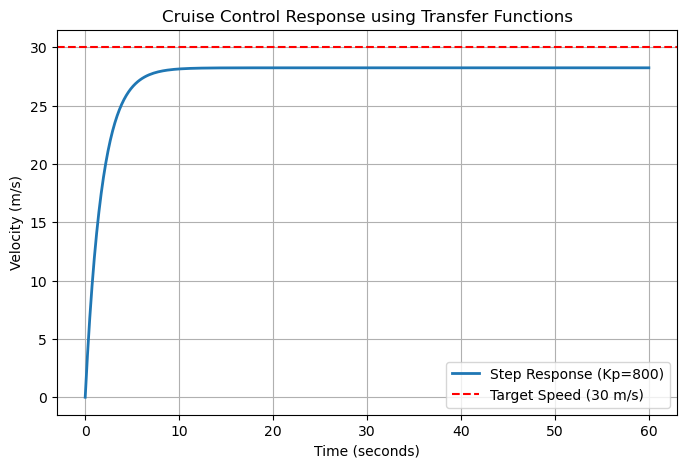

Closed-Loop Transfer Function:
<TransferFunction>: sys[78]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

      800
  ------------
  1500 s + 850
Plant Transfer Function:
<TransferFunction>: sys[74]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

       1
  -----------
  1500 s + 50
Controller Function:
<TransferFunction>: sys[75]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
dt = None

  800
  ---
   1


In [30]:
import control as ct

# Define System Parameters
m = 1500  # Mass
b = 50    # Friction
Kp = 800  # Proportional Gain

# Define the Transfer Functions
# Plant P(s) = 1 / (ms + b)
num_G = [1]
den_G = [m, b]
G = ct.TransferFunction(num_p, den_p)

# Controller C(s) = Kp
C = ct.TransferFunction([Kp], [1])

# Form the Closed-Loop System
# T(s) = (C*G) / (1 + C*G)
system = ct.feedback(C * G)

# Simulation: Step Response
# We multiply by v_target to simulate a target speed 
time, velocity = ct.step_response(system, T=60)
velocity = velocity * v_target 

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(time, velocity, label=f'Step Response (Kp={Kp})', linewidth=2)
plt.axhline(y=30, color='r', linestyle='--', label='Target Speed (30 m/s)')
plt.title('Cruise Control Response using Transfer Functions')
plt.xlabel('Time (seconds)')
plt.ylabel('Velocity (m/s)')
plt.grid(True)
plt.legend()
plt.show()

# Display the Transfer Function
print(f"Closed-Loop Transfer Function:\n{system}")
# Display the Transfer Function
print(f"Plant Transfer Function:\n{G}")
# Display the Transfer Function
print(f"Controller Function:\n{C}")

### 3. State space model

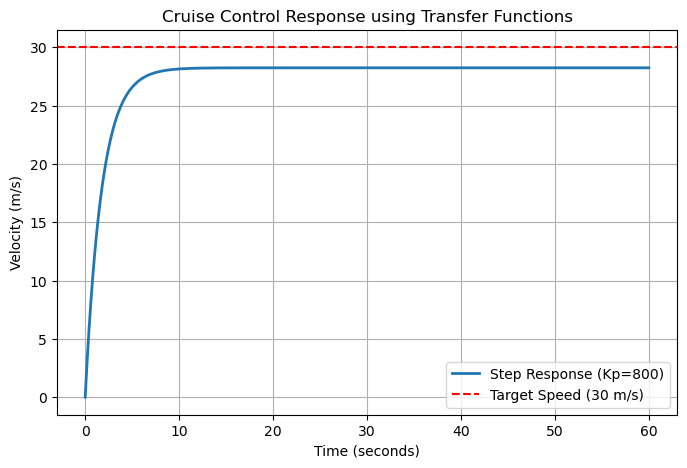

In [27]:
#  System Parameters
m = 1500    # Mass (kg)
b = 50      # Drag/Friction (N*s/m)
Kp = 800    # Proportional Gain
v_target = 30 # Target speed (m/s)

# x_dot = Ax + Bu
# y = Cx + Du
# For velocity: A = [-b/m], B = [1/m], C = [1], D = [0]
A = [[-b/m]]
B = [[1/m]]
C = [[1]]
D = [[0]]
sys_ss = ct.ss(A, B, C, D)

# Closed-loop SS: u = Kp(reference - y)
cl_ss = ct.feedback(Kp * sys_ss)

# Simulation
t = np.linspace(0, 60, 600)

# Step response returns (time, output)
# We multiply by v_target because step_response defaults to a step of 1
t_tf, y_tf = ct.step_response(cl_tf, T=t)
t_ss, y_ss = ct.step_response(cl_ss, T=t)

y_tf *= v_target
y_ss *= v_target

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(t_ss, y_ss, label=f'Step Response (Kp={Kp})', linewidth=2)
plt.axhline(y=30, color='r', linestyle='--', label='Target Speed (30 m/s)')
plt.title('Cruise Control Response using Transfer Functions')
plt.xlabel('Time (seconds)')
plt.ylabel('Velocity (m/s)')
plt.grid(True)
plt.legend()
plt.show()